# Linear Regression with Gaussian Noise

Note: Significant part of this is adapted/reproduced from: https://towardsdatascience.com/an-introduction-to-bayesian-inference-in-pystan-c27078e58d53

In [2]:
import os
import pickle
import pystan
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import multiprocessing

In [3]:
multiprocessing.set_start_method("fork")  # For using multiprocessing mode of stan
sns.set()  # Nice plot aesthetic
np.random.seed(101)

\begin{equation}
Y \propto \mathcal{N} (\alpha + \beta X, \sigma)
\end{equation}
with $\alpha$ the intercept, $\beta$ a gradient, and $\sigma$ the standard deviation of the gaussian noise.

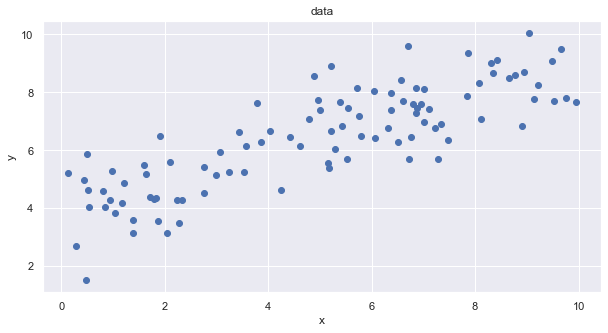

In [4]:
# Parameters to be inferred
alpha = 4.0
beta = 0.5
sigma = 1.0

# Generate data
x = 10 * np.random.rand(100)
y = alpha + beta * x
y = np.random.normal(y, scale=sigma)

# Plot data
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(x, y)

# Pimp your plot
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('data')

plt.show()

### Format the data

In [5]:
# Put our data in a dictionary
data = {'N': len(x), 'x': x, 'y': y}
pd.DataFrame(data)

,N,x,y
0,100,5.163986,5.535214
1,100,5.706676,8.146103
2,100,0.284742,2.674857
3,100,1.715217,4.363513
4,100,6.852770,7.263850
...,...,...,...
95,100,8.422194,9.108893
96,100,3.849377,6.255554
97,100,5.516658,5.695280
98,100,7.105381,7.427310


### Model definition

In [6]:
model = """
data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}
model {
    y ~ normal(alpha + beta * x, sigma);
}
"""

### Compile the model

In [9]:
# Put it to true if you edit the model
force_compilation = False

# Where to save backup
bkp_folder = 'bkp'
os.makedirs(bkp_folder, exist_ok=True)
bkp_file = os.path.join(bkp_folder, 'regression_model.pkl')
if not os.path.exists(bkp_file) or force_compilation:
    
    # Compile the model
    sm = pystan.StanModel(model_code=model)
    
    # Save the model
    with open(bkp_file, 'wb') as f:
        pickle.dump(sm, f)
else:
    # Load the model
    sm = pickle.load(open(bkp_file, 'rb'))

### Sampling

* `iter`: number of samples that will be generated from each Markov chain, 
* `chains`: number of chains from which samples will be combined to form the posterior distribution. Because the underlying Markov process is stochastic, it's advantageous to have more chains that will initialise at different locations in parameter space, though adding more chains will increase the amount of time it takes to sample. 
* `warmup` (also known as 'burn-in'): number of samples that will be discarded from the beginning of each chain. As the early samples will be drawn when the Markov chain hasn't had a chance to reach equilibrium. By default this is half of iter, so for each chain we'll get 1000 samples, and chuck away the first 500. With 4 chains, we'll have 2000 samples in total.
* `thin`: interval in sampling at which samples are retained. E.g.: if thin is equal to 3, every third sample is retained and the rest are discarded. This can be necessary to mitigate the effect of correlation between successive samples. It's set to 1 here, and so every sample is retained. 
* `seed`: Seed for the random generator. It allows for reproducibility.

In [10]:
# Train the model and generate samples
fit = sm.sampling(data=data, iter=1000, chains=4, warmup=500, thin=1, seed=101)
fit

Inference for Stan model: anon_model_cb4cc9c2a04d0e34d711077557307fb7.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   3.85  7.8e-3    0.2   3.43   3.71   3.84   3.99   4.25    689    1.0
beta    0.52  1.4e-3   0.04   0.45   0.49   0.52   0.54   0.59    695   1.01
sigma   1.02  2.2e-3   0.07   0.89   0.97   1.02   1.06   1.17   1055    1.0
lp__  -50.67    0.05    1.2 -53.74 -51.18 -50.38 -49.82 -49.27    660   1.01

Samples were drawn using NUTS at Tue Jan  5 15:52:26 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

Results give summary statistics for three parameters of our model and for:
* `lp__`: the log posterior density up to a constant. Checking that `lp__` has converged allows greater confidence that the whole sampling process has converged, but the value itself isn't particularly important.

In addition to the mean and quantile information, each parameter has two further columns:
* `n_eff`: the [effective sample size](https://en.wikipedia.org/wiki/Effective_sample_size), which because of correlation between samples, can be significantly lower than the nominal amount of samples generated. The effect of [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) can be mitigated by thinning the Markov chains (parameter `thin`). 
* `Rhat` is the [Gelman-Rubin](http://digitalassets.lib.berkeley.edu/sdtr/ucb/text/307.pdf) convergence statistic, a measure of Markov chain convergence, and corresponds to the scale factor of variance reduction that could be observed if sampling were allowed to continue forever. So if `Rhat` is approximately 1, you would expect to see no decrease in sampling variance regardless of how long you continue to iterate, and so the Markov chain is likely (but not guaranteed) to have converged.

In [11]:
# Cast the fit output to a pandas DataFrame
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])
df

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha,3.847233,0.007791,0.204476,3.432199,3.712045,3.843945,3.988621,4.247307,688.824561,1.003806
beta,0.518992,0.001357,0.035774,0.451554,0.494031,0.519022,0.542252,0.592751,694.847442,1.005137
sigma,1.018336,0.002230,0.072411,0.889964,0.966515,1.015352,1.062878,1.171441,1054.666326,1.003536
lp__,-50.670761,0.046689,1.199146,-53.741125,-51.180655,-50.381009,-49.823333,-49.274058,659.640882,1.009254


## Plot

In [12]:
# Extract means
alpha_mean, beta_mean = df['mean']['alpha'], df['mean']['beta']

# Extracting traces
alpha = fit['alpha']
beta = fit['beta']

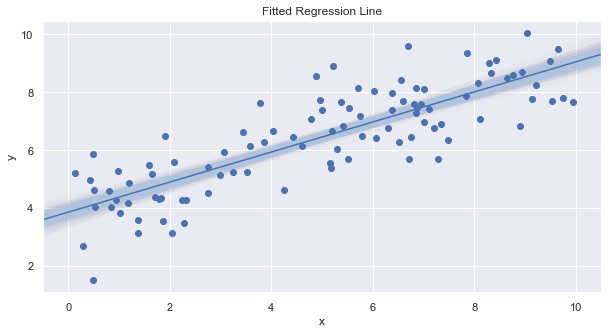

In [13]:
def f(x, alpha, beta):
    return alpha + beta * x

# Extract means
alpha_mean, beta_mean = df['mean']['alpha'], df['mean']['beta']

# Extracting traces
alpha = fit['alpha']
beta = fit['beta']

# Set limits
x_min, x_max = -0.5, 10.5

# Generate x-values
x_plot = np.linspace(x_min, x_max, 100)

# Create fig
fig, ax = plt.subplots(figsize=(10, 5))

# Plot a subset of sampled regression lines
n = 1000
idx = np.random.choice(range(len(alpha)), size=n, replace=False)
for i in idx:
    ax.plot(x_plot, f(x_plot, alpha[i], beta[i]), color='lightsteelblue', alpha=0.005 )

# Plot fitted model  
ax.plot(x_plot, f(x_plot, alpha_mean, beta_mean))
            
# Plot original data
ax.scatter(x, y)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Fitted Regression Line')
ax.set_xlim(x_min, x_max)

plt.show()

For diagnositic/sanity check, we can represent:
* the 'trace' for each parameter: the sequence of sampled values for each parameter,  
* the corresponding posterior distributions

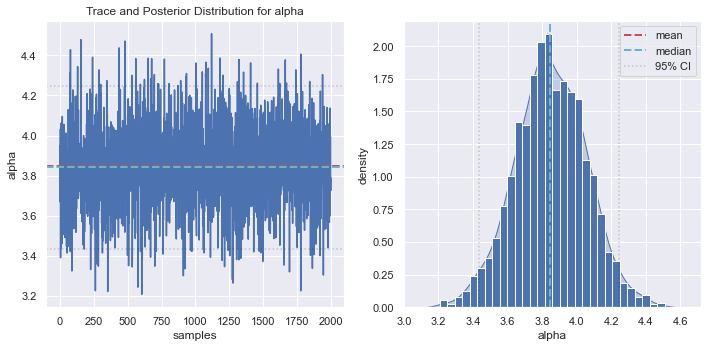

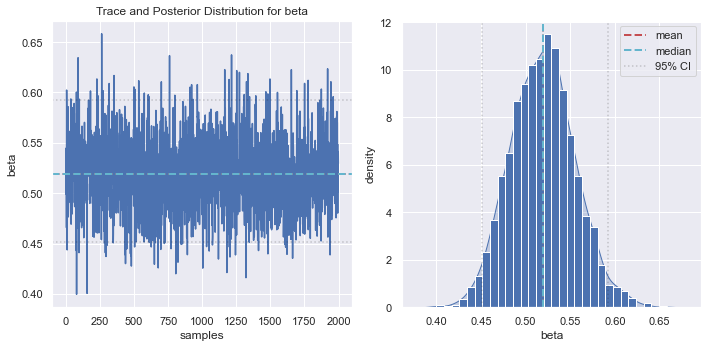

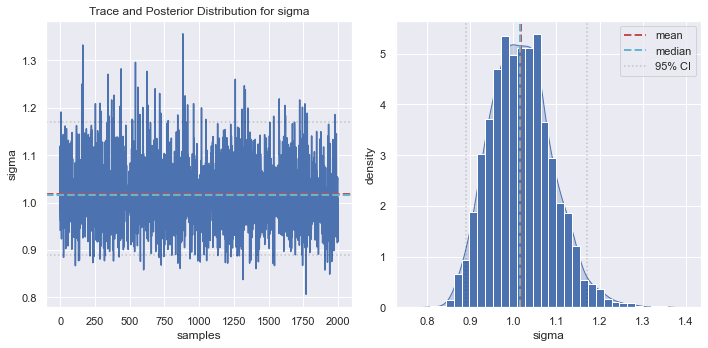

In [13]:
for param_name in ("alpha", "beta", "sigma"):

    # Extract trace
    param = fit[param_name]

    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)

    # Plotting
    fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
    
    ax = axes[0]
    ax.plot(param)
    ax.set_xlabel('samples')
    ax.set_ylabel(param_name)
    ax.axhline(mean, color='r', lw=2, linestyle='--')
    ax.axhline(median, color='c', lw=2, linestyle='--')
    ax.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
    ax.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
    ax.set_title('Trace and Posterior Distribution for {}'.format(param_name))

    ax = axes[1]
    ax.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
    ax.set_xlabel(param_name)
    ax.set_ylabel('density')
    ax.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
    ax.axvline(median, color='c', lw=2, linestyle='--',label='median')
    ax.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
    ax.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
    ax.legend()
    
    plt.tight_layout()